<img src="../logo_UTN.svg" align="right" width="200" /> 

# Tarea semanal 10
## Manuel Dieguez

# ¿Que vamos a estudiar en esta tarea?

En esta tarea vamos a probar algunos ejemplos de filtrado no lineal en nuestro ECG


In [25]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io.wavfile import write
import warnings
warnings.filterwarnings('ignore')

In [26]:
def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

##################
# Lectura de ECG #
##################

fs_ecg = 1000 # Frecuencia de muestreo del ECG en Hz
N = 40000     # Muestras a tomar del ECG
t = np.arange(0, N/fs_ecg, 1/fs_ecg)
#w = 10

# para listar las variables que hay en el archivo

mat_struct = sio.loadmat('./ECG_TP4.mat')

#ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
ecg_one_lead = mat_struct['ecg_lead'].flatten()
qrs_detections = mat_struct['qrs_detections'].flatten()
ecg_one_lead_cut = ecg_one_lead[0:N]

t_full = np.arange(0,len(ecg_one_lead)/fs_ecg, 1/fs_ecg)

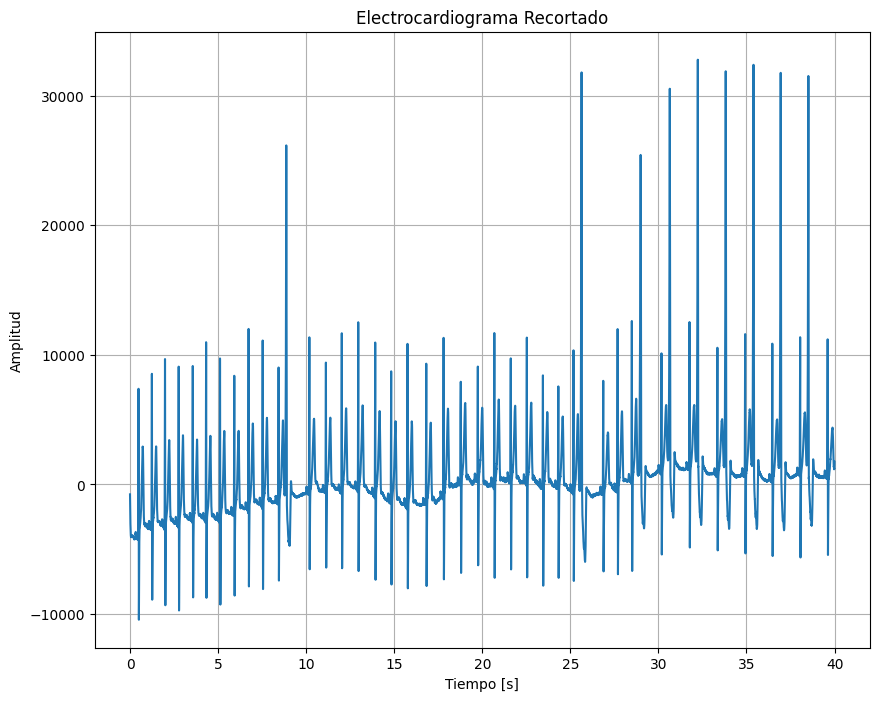

In [27]:
plt.figure(1, figsize=(10,8))
plt.title("Electrocardiograma Recortado")
plt.ylabel("Amplitud")
plt.xlabel("Tiempo [s]")
plt.plot(t,ecg_one_lead_cut)
#plt.plot(np.arange(0,N/fs_ecg,1/fs_ecg), ecg_one_lead_cut)
plt.grid()


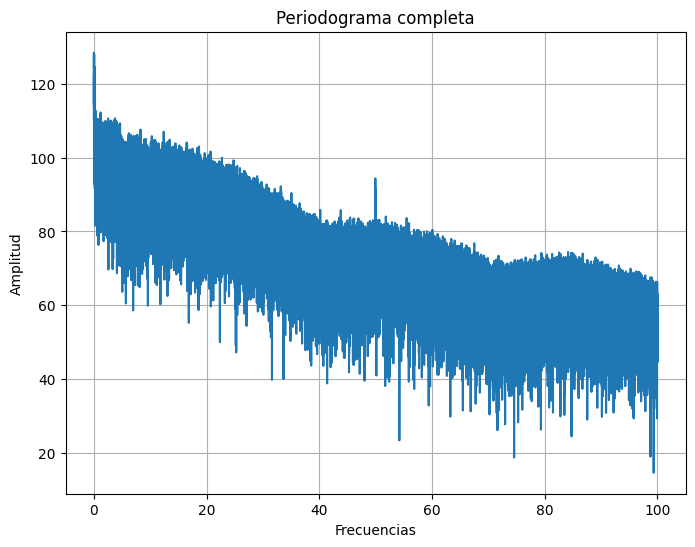

In [28]:
## Peridograma simple de la senal completa
freqs_full = np.fft.fftfreq(len(ecg_one_lead), d=1/fs_ecg)
fft_ecg_full = np.fft.fft(ecg_one_lead)
Pxx_ecg_full = np.abs(fft_ecg_full)**2/N
i = int(len(freqs_full)/2)
bool_index = (freqs_full >= 0) & (freqs_full <= 100)

plt.figure(2, figsize=(8,6))
plt.title("Periodograma completa")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_full[bool_index],10*np.log10(Pxx_ecg_full)[bool_index])
plt.grid()
plt.show()

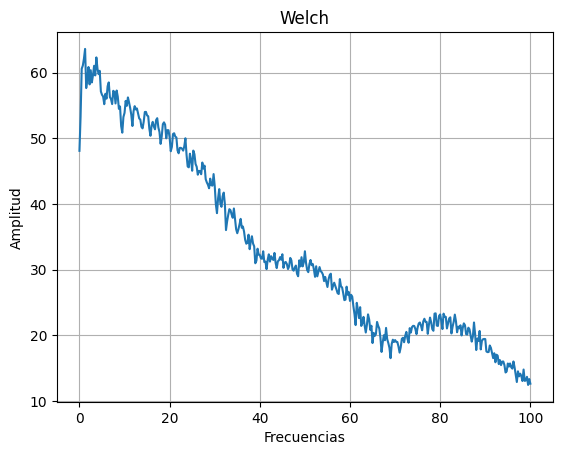

In [29]:
## Hacemos la estimacion de Welch para las primeras N muestras del ECG
w = 10
[freqs_welch, fft_welch] = sc.signal.welch(ecg_one_lead_cut, fs_ecg, window = "hann", nperseg = int(N/w), detrend ="linear") ## Detrend saca la pendiente
bool_index = (freqs_welch >= 0) & (freqs_welch <= 100)

plt.figure(4)
plt.title("Welch")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_welch[bool_index],10*np.log10(fft_welch)[bool_index])
plt.grid()
plt.show()

## Filtro de medianas

El filtro de medianas es un filtrado no lineal que utiliza las medianas de la senal para eliminar el ruido. 

El mismo se calcula con ventanas deslizantes en cada muestra, tomando una ventana de 200 muestras y quedandose con la media, luego al resultado se le vuelve a aplicar un filtro de mediana pero de 600 muestras, tal que:

$$ \hat{b} = \mathop{med}_{600} \{ \mathop{med}_{200} \{s\} \} $$

Luego, restamos el resultado a la senal de forma que:

$$ \hat{x} = s - \hat{b} $$

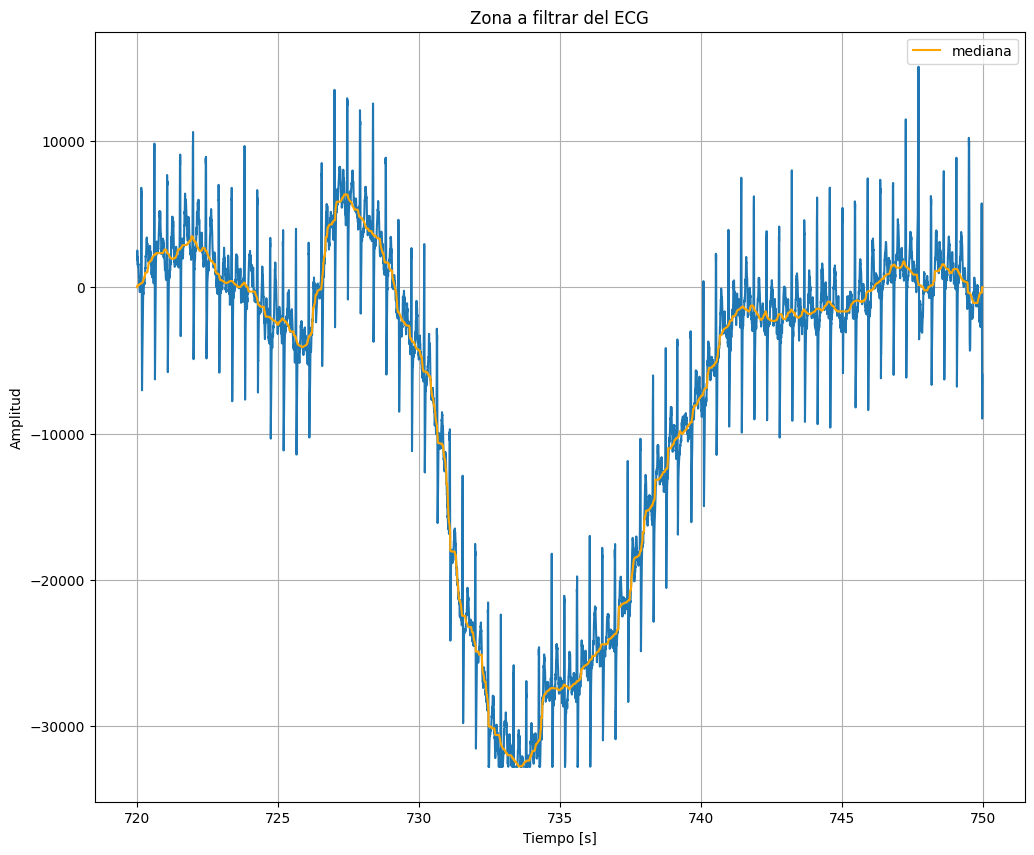

In [46]:
zoom_region = np.arange(720000,750000)
ecg_med = sc.signal.medfilt(sc.signal.medfilt(ecg_one_lead[zoom_region], 201),601)

plt.figure(5, figsize=(12,10))
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Zona a filtrar del ECG")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region])
plt.plot(t_full[zoom_region], ecg_med,color ="orange", label='mediana')
plt.grid()
plt.legend()
plt.show()

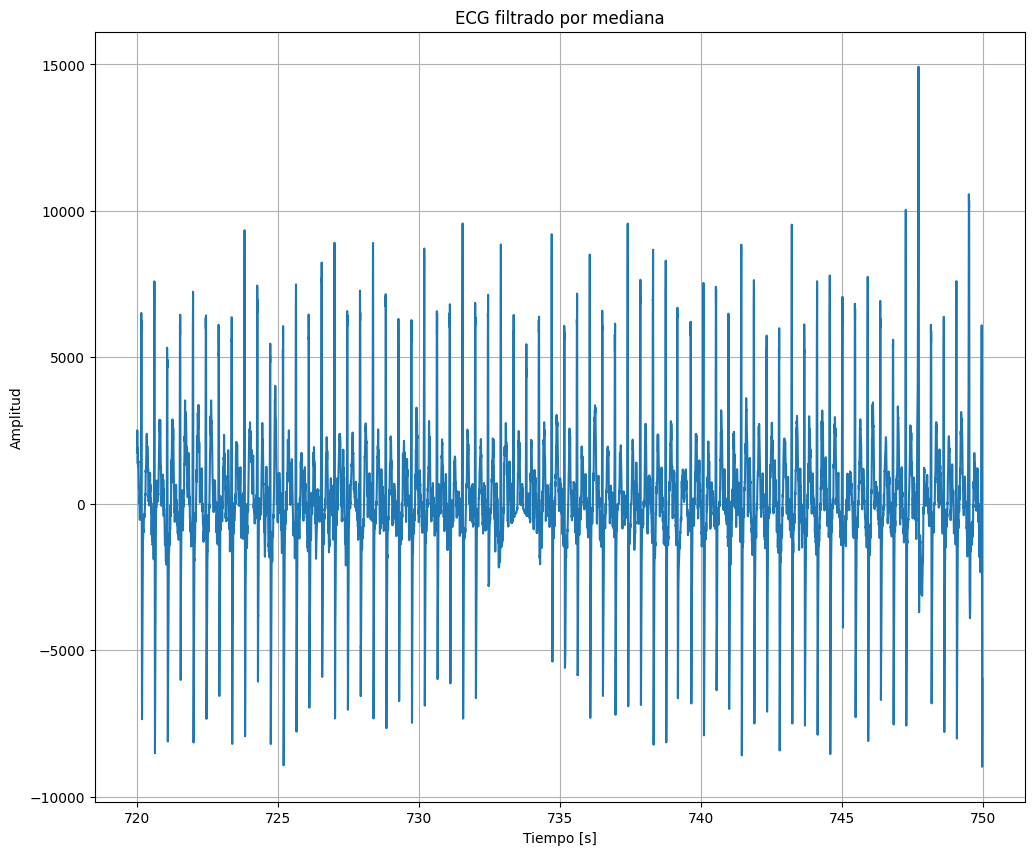

In [47]:
ecg_filt_med = ecg_one_lead[zoom_region] - ecg_med

plt.figure(6,  figsize=(12,10))
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("ECG filtrado por mediana")
plt.plot(t_full[zoom_region],ecg_filt_med)
plt.grid()
plt.show()

Podemos observar que el filtro fue sumamente efectivo para quitar la deriva de baja frecuencia, pero hay que tener en cuenta que este tipo de filtrado

## Filtrado con Cubi Spline

Un cubic spline es una técnica de interpolación que utiliza un conjunto de polinomios cúbicos por tramos para aproximar una función f(x) de manera suave entre un conjunto de puntos conocidos. A diferencia de los polinomios de alto grado, evitan oscilaciones excesivas y son precisos incluso con pocos datos. Esto tambien hace que sea menos costoso computacionalmente que un filtro de mediana

Para aplicarlo, vamos a usar la funcion de Scipy

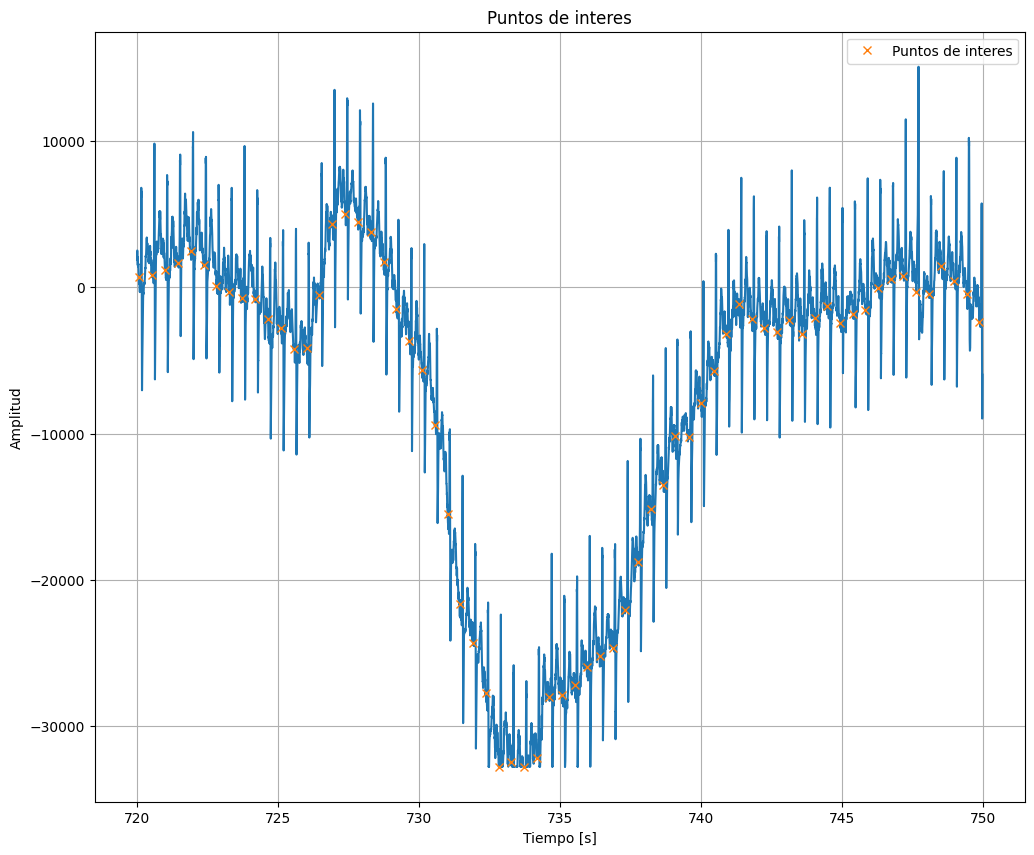

In [54]:
offset_ms = 80 ## Offset en milisegundos
offset_samples = int(offset_ms*1e-3*fs_ecg)

marcas_qrs = qrs_detections[(qrs_detections >= zoom_region[0]) & (qrs_detections <= zoom_region[-1])] - offset_samples

plt.figure(7, figsize=(12,10))
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Puntos de interes")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region])
plt.plot(t_full[marcas_qrs], ecg_one_lead[marcas_qrs], 'x', label='Puntos de interes')
plt.grid()
plt.legend()
plt.show()

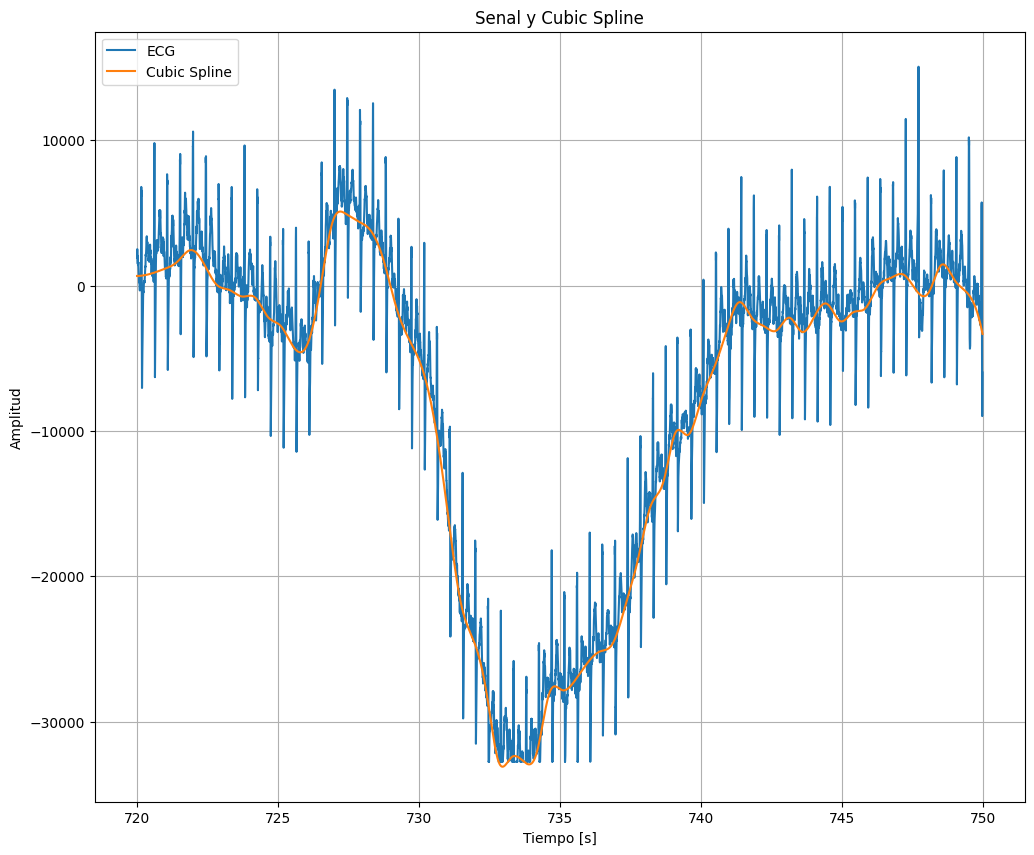

In [64]:
cubic_spl = sc.interpolate.CubicSpline(marcas_qrs, ecg_one_lead[marcas_qrs])
ecg_cubic = cubic_spl(zoom_region)

plt.figure(7, figsize=(12,10))
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Senal y Cubic Spline")
plt.plot(t_full[zoom_region],ecg_one_lead[zoom_region], label= "ECG")
plt.plot(t_full[zoom_region], ecg_cubic, label='Cubic Spline')
plt.grid()
plt.legend()
plt.show()

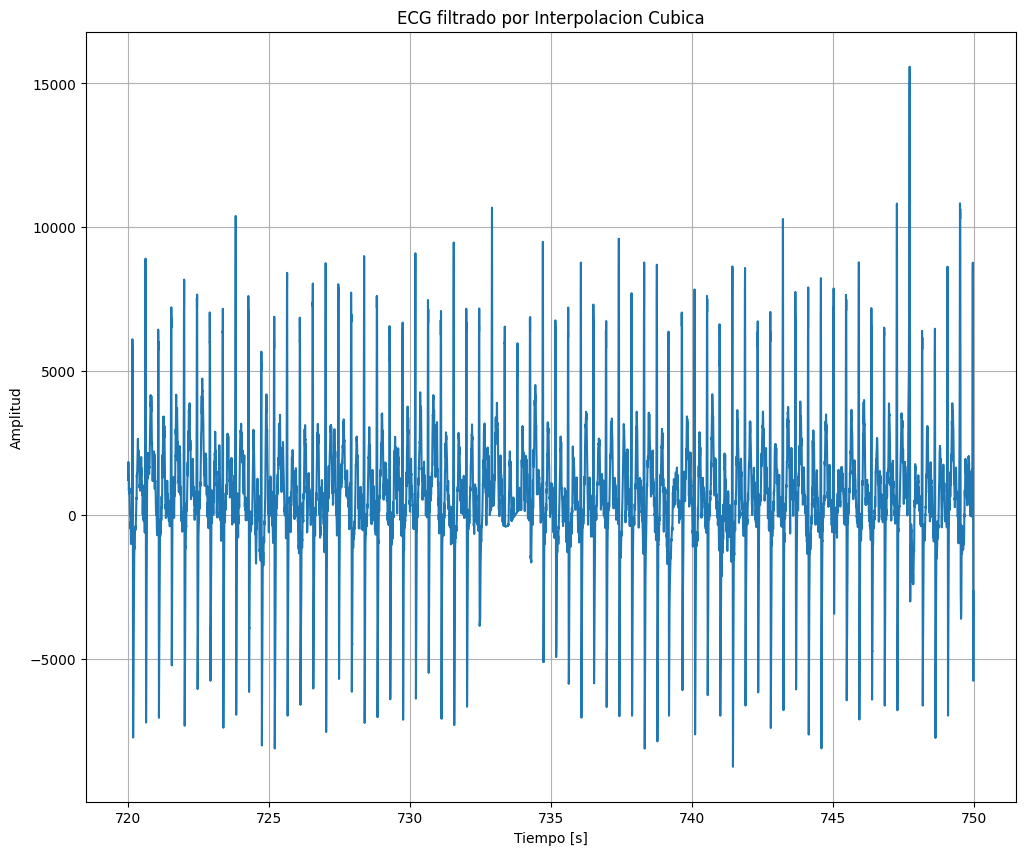

In [65]:
ecg_filt_cubic = ecg_one_lead[zoom_region] - ecg_cubic

plt.figure(9,  figsize=(12,10))
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("ECG filtrado por Interpolacion Cubica")
plt.plot(t_full[zoom_region],ecg_filt_cubic)
plt.grid()
plt.show()

## Conclusion

El filtro de medianas no solamente elimino la deriva de la senal con mayor precision (verlo en los graficos de la ECG junto su estimador), sino que tambien elimino componentes mas rapidas, este seguimiento mas preciso lo hace a costa de un procesamiento mayor contra Cubic Spline, haciendolo mas dificil en senales de muchas muestras. 

Tambien vemos que es importar conocer la naturaleza de nuestra senal y en que frecuencias tenemos informacion, ya que si nuestra senal tiene informacion en altas frecuencias, el metodo de filtrado por mediana nos podria hacer perder informacion.